# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></div><div class="lev1 toc-item"><a href="#Trial-Duration" data-toc-modified-id="Trial-Duration-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Trial Duration</a></div><div class="lev1 toc-item"><a href="#Intertrial-Interval" data-toc-modified-id="Intertrial-Interval-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Intertrial Interval</a></div><div class="lev1 toc-item"><a href="#Stationary-analysis" data-toc-modified-id="Stationary-analysis-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Stationary analysis</a></div><div class="lev1 toc-item"><a href="#Hidden-Markov-Model" data-toc-modified-id="Hidden-Markov-Model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Hidden Markov Model</a></div>

# Imports

In [3]:
# Data manipulation
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

# spikelearn
import os
os.chdir('../../')
import sys
sys.path.append('.')

from spikelearn.data import io
from spikelearn.data.selection import select
from spikelearn.visuals.visuals import raster_multiple, raster_plot

In [4]:
# Definitions
DRRD_RATS = ['DRRD 7','DRRD 8','DRRD 9','DRRD 10']
AUTOSHAPE_RATS = ['Autoshape 7','Autoshape 8','Autoshape 9','Autoshape 10']
ALL_RATS = DRRD_RATS + AUTOSHAPE_RATS

# Facilitators
BASE_FIG_SIZE = np.array([20, 4])
mpl.rc("figure", figsize=BASE_FIG_SIZE)
per_rat_plot = lambda nplots, rats: plt.subplots(nplots, len(rats), sharey=True, figsize=BASE_FIG_SIZE*[1, nplots])
# example: fig, axes = per_rat_plot(4)

In [5]:
from scipy.signal import detrend
from statsmodels.tsa.vector_ar import var_model
from statsmodels.tsa.filters.filtertools import recursive_filter
from statsmodels.tsa.statespace.varmax import VARMAX

/home/registroeletrofisio/miniconda3/envs/ratLearn/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Trial Duration

# Intertrial Interval

In [372]:
bhv = {}
for label in ALL_RATS:
    bhv[label] = select(io.load(label, 'behav_stats'), is_tired=False)

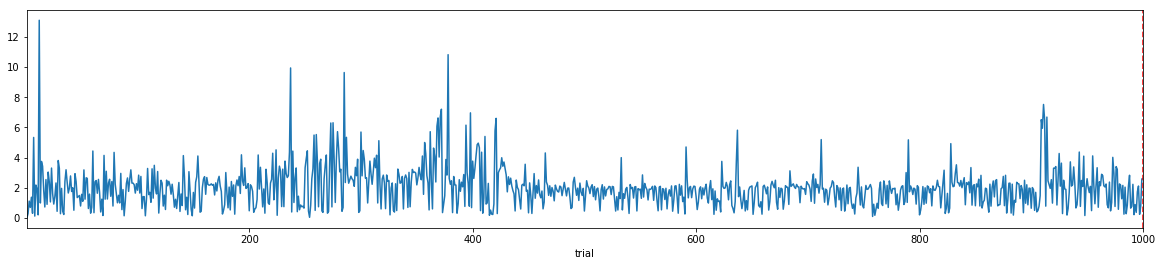

In [388]:
rat = 'DRRD 7'
bhv[rat]['intertrial_interval'].apply(np.sqrt).plot();

# My choice for cropping the session
plt.axvline(1000, linestyle='--', color='r')

# Stationary analysis

In [389]:
def detrend_VAR(arr):
    d = var_model.VAR(arr)
    order = d.select_order(20)
    res = d.fit(order['bic'])
    residuals = arr[order['bic']:] - res.fittedvalues
    return residuals

In [390]:
def detrend_VARMAX(arr, exog=None):
    d = var_model.VAR(arr)
    order = d.select_order(20)
    
    vmax = VARMAX(arr, exog, (order['bic'], 2), enforce_stationarity=False)
    res = vmax.fit(maxiter=200)
    residuals = arr - res.fittedvalues
    return residuals

In [391]:
bhv[rat]['rewarded'] = np.hstack((0, (bhv[rat]['duration']>1.5).values[:-1] ))

In [392]:
residuals = detrend_VAR(bhv[rat][['duration','intertrial_interval', 'rewarded']].values)

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0         2.810        2.825        16.61        2.816
1         1.970        2.030        7.172        1.993
2         1.922       2.027*        6.836        1.962
3         1.902        2.052        6.700        1.959
4         1.883        2.078        6.575       1.957*
5         1.888        2.127        6.607        1.979
6        1.855*        2.139       6.391*        1.963
7         1.859        2.188        6.417        1.984
8         1.861        2.235        6.433        2.004
9         1.872        2.291        6.503        2.032
10        1.869        2.333        6.481        2.045
11        1.877        2.385        6.533        2.070
12        1.892        2.445        6.631        2.102
13        1.900        2.499        6.689        2.128
14        1.910        2.553        6.755        2.155
15        

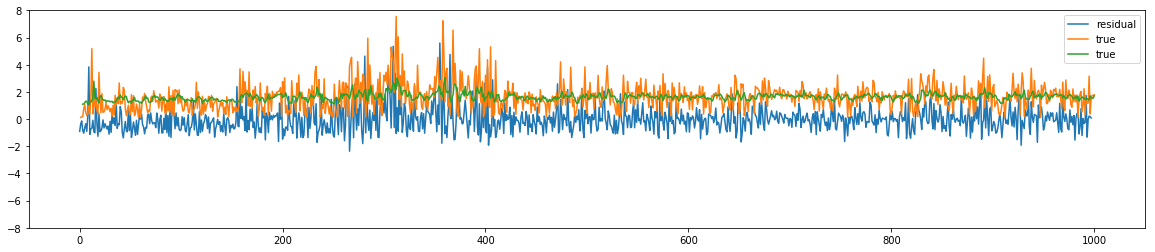

In [401]:
plt.plot(residuals[:,0], label='residual'); plt.ylim(-8,8)
plt.plot(bhv[rat]['duration'], label='true'); plt.ylim(-8,8)
plt.plot(bhv[rat]['duration'][2:]-residuals[:,0], label='true'); plt.ylim(-8,8)
#plt.plot(residuals[:,1], label='ITI',alpha=.5); 
plt.legend()

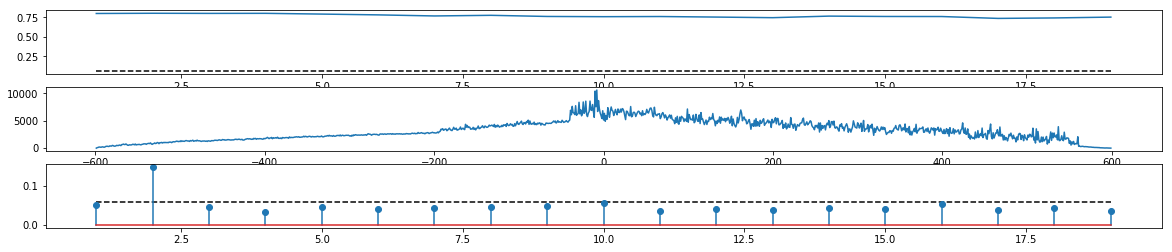

In [382]:
acorr = np.correlate(bhv[rat]['intertrial_interval'], bhv[rat]['intertrial_interval'], 2)
acorr /= acorr.max()
xcorr = np.correlate(bhv[rat]['intertrial_interval'], bhv[rat]['duration'], 2)
x = np.arange(-bhv[rat].shape[0]+1,bhv[rat].shape[0])
to_plot = np.logical_and(x>0, x<20)
dcorr = np.correlate(bhv[rat]['duration'], bhv[rat]['duration'], 2)
dcorr /= dcorr.max()


plt.subplot(3,1,1)
plt.plot(x[to_plot],dcorr[to_plot]);
plt.hlines(2/np.sqrt(len(acorr/2)),x[to_plot][0], x[to_plot][-1], linestyles='--')
plt.subplot(3,1,2)
plt.plot(x,xcorr);
plt.subplot(3,1,3)
plt.stem(x[to_plot], acorr[to_plot]);
plt.hlines(2/np.sqrt(len(acorr/2)),x[to_plot][0], x[to_plot][-1], linestyles='--')

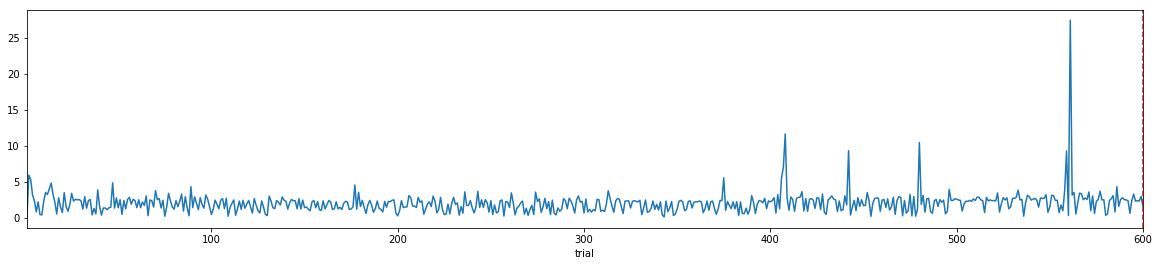

In [402]:
rat = 'DRRD 8'
bhv[rat]['intertrial_interval'].apply(np.sqrt).plot()

# My choice for cropping the session
plt.axvline(600, linestyle='--', color='r')

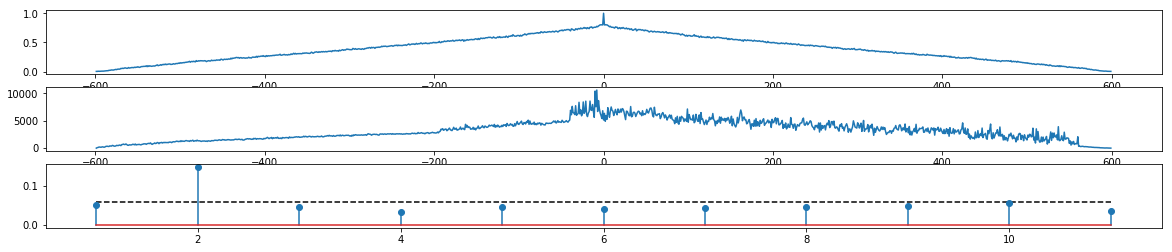

In [403]:
acorr = np.correlate(bhv[rat]['intertrial_interval'], bhv[rat]['intertrial_interval'], 2)
acorr /= acorr.max()
xcorr = np.correlate(bhv[rat]['intertrial_interval'], bhv[rat]['duration'], 2)
x = np.arange(-bhv[rat].shape[0]+1,bhv[rat].shape[0])
to_plot = np.logical_and(x>0, x<12)
dcorr = np.correlate(bhv[rat]['duration'], bhv[rat]['duration'], 2)
dcorr /= dcorr.max()


plt.subplot(3,1,1)
plt.plot(x,dcorr);
plt.subplot(3,1,2)
plt.plot(x,xcorr);
plt.subplot(3,1,3)
plt.stem(x[to_plot], acorr[to_plot]);
plt.hlines(2/np.sqrt(len(acorr/2)),x[to_plot][0], x[to_plot][-1], linestyles='--')

In [404]:
bhv[rat]['rewarded'] = np.hstack((0, (bhv[rat]['duration']>1.5).values[:-1] ))
residuals = detrend_VAR(bhv[rat][['duration','intertrial_interval', 'rewarded']].values)

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0         5.309        5.332        202.2        5.318
1         4.518       4.609*        91.68        4.554
2         4.489        4.646        88.99       4.550*
3         4.498        4.724        89.84        4.586
4         4.519        4.812        91.70        4.633
5         4.521        4.882        91.96        4.662
6         4.520        4.948        91.81        4.687
7         4.522        5.019        92.05        4.716
8         4.465        5.029        86.89        4.684
9         4.458        5.090        86.32        4.704
10        4.440        5.139        84.79        4.713
11       4.413*        5.180       82.55*        4.712
12        4.427        5.262        83.74        4.753
13        4.436        5.339        84.50        4.788
14        4.451        5.422        85.82        4.830
15        

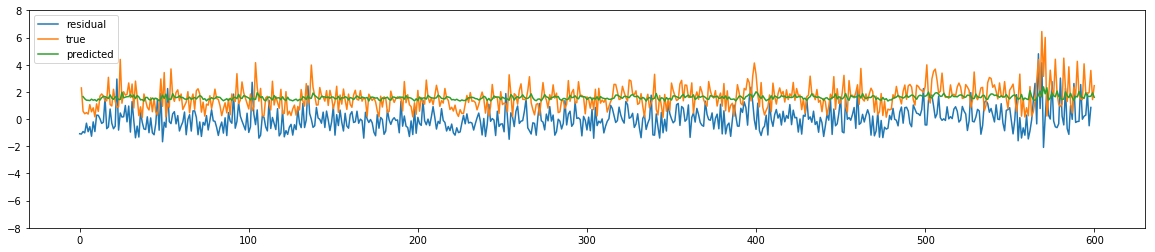

In [407]:
plt.plot(residuals[:,0], label='residual'); plt.ylim(-8,8)
plt.plot(bhv[rat]['duration'], label='true'); plt.ylim(-8,8)
plt.plot(bhv[rat]['duration'][1:]-residuals[:,0], label='predicted'); plt.ylim(-8,8)
#plt.plot(residuals[:,1], label='ITI',alpha=.5); 
plt.legend()

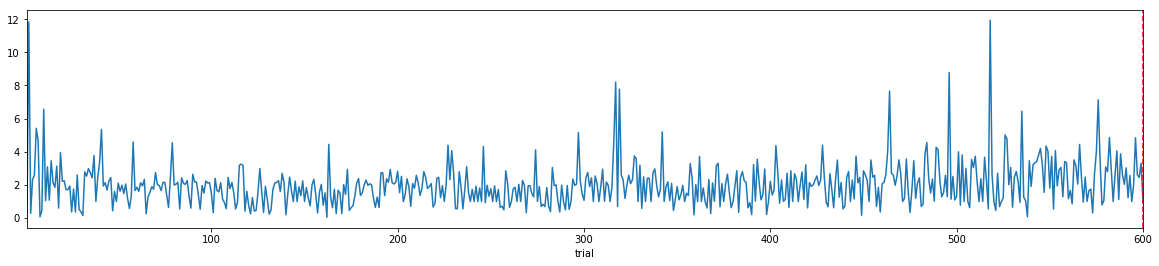

In [408]:
rat = 'DRRD 9'
bhv[rat]['intertrial_interval'].apply(np.sqrt).plot()

# My choice for cropping the session
plt.axvline(600, linestyle='--', color='r')

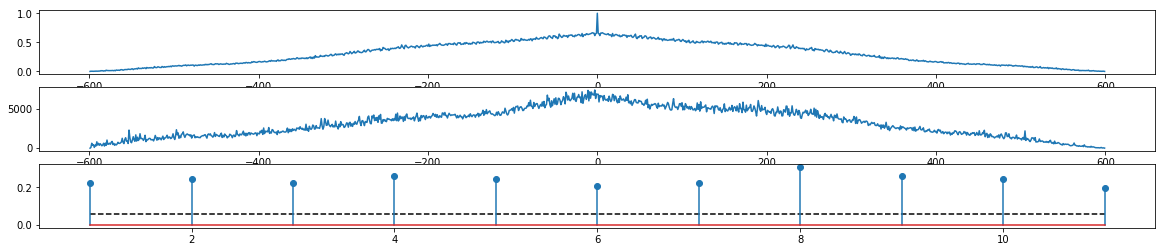

In [409]:
acorr = np.correlate(bhv[rat]['intertrial_interval'], bhv[rat]['intertrial_interval'], 2)
acorr /= acorr.max()
xcorr = np.correlate(bhv[rat]['intertrial_interval'], bhv[rat]['duration'], 2)
x = np.arange(-bhv[rat].shape[0]+1,bhv[rat].shape[0])
to_plot = np.logical_and(x>0, x<12)
dcorr = np.correlate(bhv[rat]['duration'], bhv[rat]['duration'], 2)
dcorr /= dcorr.max()


plt.subplot(3,1,1)
plt.plot(x,dcorr);
plt.subplot(3,1,2)
plt.plot(x,xcorr);
plt.subplot(3,1,3)
plt.stem(x[to_plot], acorr[to_plot]);
plt.hlines(2/np.sqrt(len(acorr/2)),x[to_plot][0], x[to_plot][-1], linestyles='--')

In [410]:
bhv[rat]['rewarded'] = np.hstack((0, (bhv[rat]['duration']>1.5).values[:-1] ))
residuals = detrend_VAR(bhv[rat][['duration','intertrial_interval', 'rewarded']].values)

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0         3.818        3.841        45.53        3.827
1        3.156*       3.246*       23.48*       3.191*
2         3.171        3.329        23.84        3.233
3         3.183        3.409        24.13        3.271
4         3.178        3.471        24.00        3.292
5         3.184        3.545        24.15        3.325
6         3.204        3.633        24.64        3.371
7         3.217        3.714        24.96        3.411
8         3.227        3.791        25.21        3.447
9         3.232        3.864        25.33        3.478
10        3.250        3.950        25.80        3.523
11        3.272        4.039        26.37        3.571
12        3.290        4.125        26.85        3.615
13        3.300        4.203        27.13        3.652
14        3.323        4.293        27.76        3.701
15        

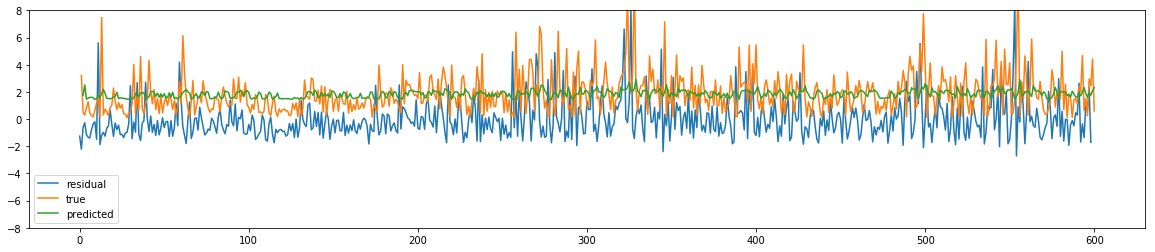

In [412]:
plt.plot(residuals[:,0], label='residual'); plt.ylim(-8,8)
plt.plot(bhv[rat]['duration'], label='true'); plt.ylim(-8,8)
plt.plot(bhv[rat]['duration'][1:]-residuals[:,0], label='predicted'); plt.ylim(-8,8)
#plt.plot(residuals[:,1], label='ITI',alpha=.5); 
plt.legend()

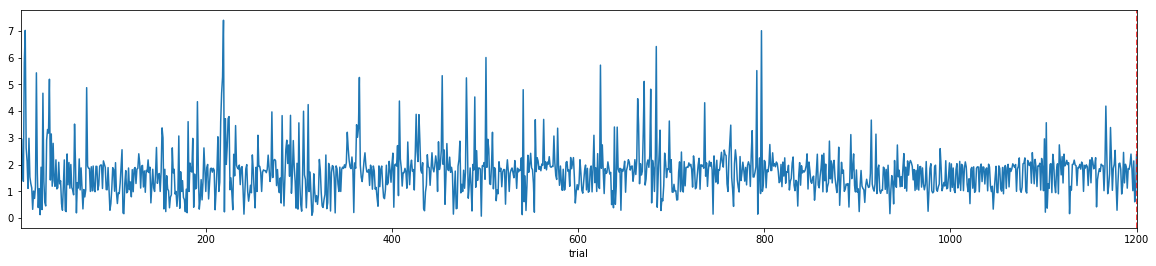

In [413]:
rat = 'DRRD 10'
bhv[rat]['intertrial_interval'].apply(np.sqrt).plot()

# My choice for cropping the session
plt.axvline(1200, linestyle='--', color='r')

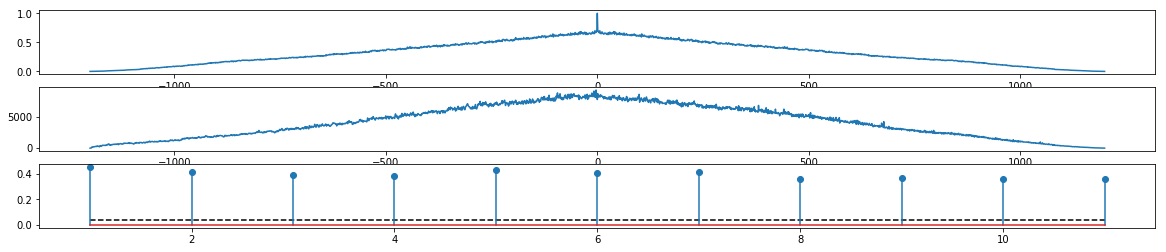

In [414]:
acorr = np.correlate(bhv[rat]['intertrial_interval'], bhv[rat]['intertrial_interval'], 2)
acorr /= acorr.max()
xcorr = np.correlate(bhv[rat]['intertrial_interval'], bhv[rat]['duration'], 2)
x = np.arange(-bhv[rat].shape[0]+1,bhv[rat].shape[0])
to_plot = np.logical_and(x>0, x<12)
dcorr = np.correlate(bhv[rat]['duration'], bhv[rat]['duration'], 2)
dcorr /= dcorr.max()


plt.subplot(3,1,1)
plt.plot(x,dcorr);
plt.subplot(3,1,2)
plt.plot(x,xcorr);
plt.subplot(3,1,3)
plt.stem(x[to_plot], acorr[to_plot]);
plt.hlines(2/np.sqrt(len(acorr/2)),x[to_plot][0], x[to_plot][-1], linestyles='--')

In [415]:
bhv[rat]['rewarded'] = np.hstack((0, (bhv[rat]['duration']>1.5).values[:-1] ))
residuals = detrend_VAR(bhv[rat][['duration','intertrial_interval', 'rewarded']].values)

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0         2.264        2.277        9.624        2.269
1         1.826       1.878*        6.209       1.845*
2         1.814        1.905        6.138        1.849
3         1.800        1.929        6.048        1.848
4         1.802        1.970        6.063        1.865
5         1.781        1.988        5.938        1.859
6         1.775        2.020        5.898        1.867
7         1.773        2.056        5.886        1.880
8        1.771*        2.094       5.878*        1.893
9         1.775        2.136        5.898        1.911
10        1.786        2.186        5.966        1.937
11        1.789        2.228        5.986        1.955
12        1.798        2.276        6.040        1.978
13        1.804        2.320        6.072        1.998
14        1.814        2.368        6.133        2.023
15        

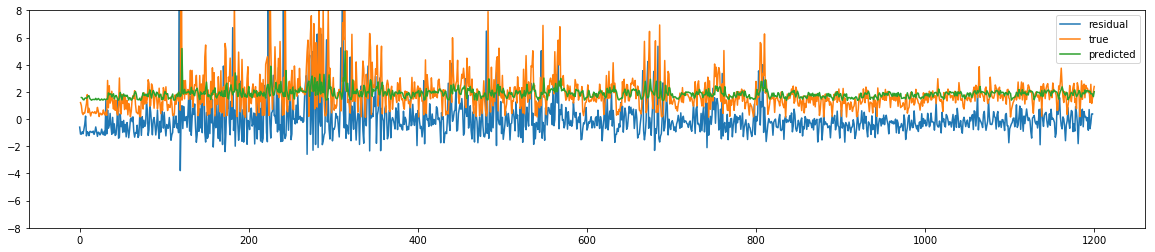

In [416]:
plt.plot(residuals[:,0], label='residual'); plt.ylim(-8,8)
plt.plot(bhv[rat]['duration'], label='true'); plt.ylim(-8,8)
plt.plot(bhv[rat]['duration'][1:]-residuals[:,0], label='predicted'); plt.ylim(-8,8)
#plt.plot(residuals[:,1], label='ITI',alpha=.5); 
plt.legend()

# Hidden Markov Model

In [4]:
from hmmlearn.hmm import GaussianHMM, GMMHMM

In [7]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [8]:
from spikelearn.data import SHORTCUTS

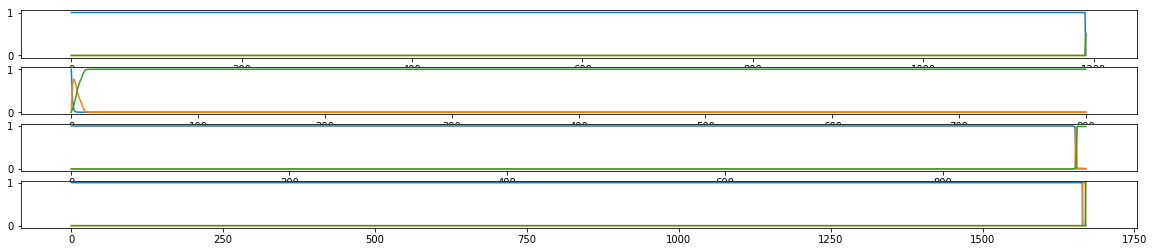

In [10]:
for i, label in enumerate(SHORTCUTS['groups']['DRRD']):
    t = io.load(label, 'behav_stats')[['duration','intertrial_interval']].values.reshape(-1,2)

    model = GaussianHMM(3, params='smc', init_params="scm", covariance_type='tied')
    model.transmat_=np.array([[1./3,1./3,1./3],[0,.5,.5],[0,0,1]]) 
    model.fit(t)

    plt.subplot(4,1,i+1)
    plt.plot(model.predict_proba(t))
    #plt.xlim([0,0])

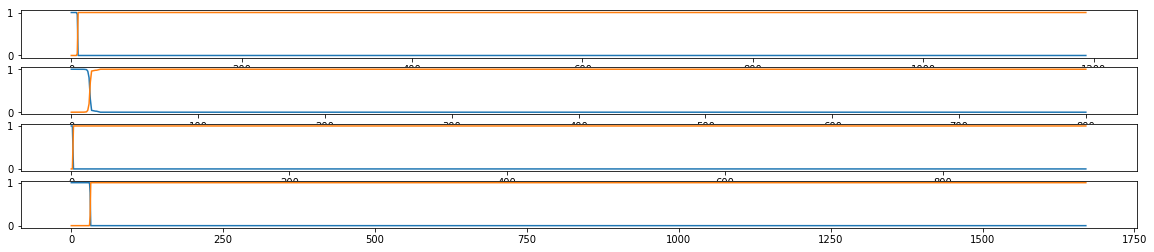

In [13]:
for i, label in enumerate(SHORTCUTS['groups']['DRRD']):
    t = io.load(label, 'behav_stats')[['duration','intertrial_interval']].values.reshape(-1,2)

    model = GMMHMM(2, 2, params='smc', init_params="scm", covariance_type='diag')
    model.transmat_=np.array([[.5,.5],[0,1]]) 
    model.fit(t)

    plt.subplot(4,1,i+1)
    plt.plot(model.predict_proba(t))
    #plt.xlim([0,0])

,onset,offset,duration,intertrial_interval,is_tired,duration prev
trial,,,,,,
1,105.777193,106.990264,1.213071,0.000000,False,NaN
2,115.756114,116.750828,0.994714,8.765850,False,1.213071
3,119.935959,120.397332,0.461373,3.185132,False,0.994714
4,122.270556,122.600407,0.329851,1.873224,False,0.461373
5,156.328469,156.804874,0.476406,33.728061,False,0.329851
6,206.114161,206.560993,0.446833,49.309286,False,0.476406
7,213.447516,214.244557,0.797041,6.886523,False,0.446833
8,218.731151,219.864474,1.133322,4.486594,False,0.797041
9,221.086966,222.890721,1.803756,1.222492,False,1.133322


/home/tevo/anaconda3/lib/python3.6/site-packages/hmmlearn/base.py:460: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
/home/tevo/anaconda3/lib/python3.6/site-packages/hmmlearn/base.py:469: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
/home/tevo/anaconda3/lib/python3.6/site-packages/hmmlearn/base.py:624: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),


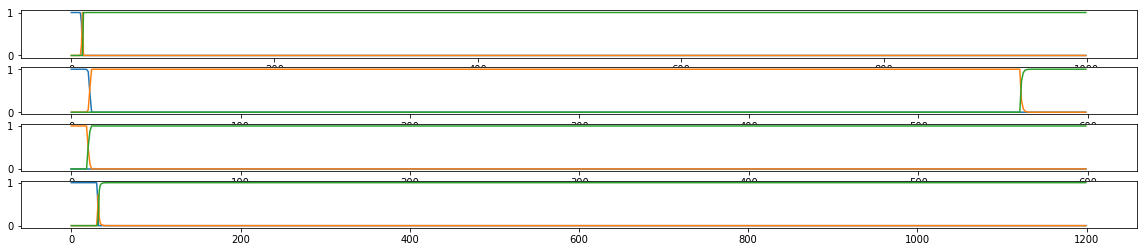

In [309]:
X, lengths = np.full((0,3), 1), []
for i, label in enumerate(SHORTCUTS['groups']['DRRD']):
    t = io.load(label, 'behav_stats')
    t = t.join(t.shift().duration, rsuffix=' prev')
    t = select(t, is_tired=False)[['duration', 'duration prev', 'intertrial_interval']].values.reshape(-1,3)
    
    X = np.nan_to_num(np.vstack((X, t)))
    lengths.append(t.shape[0])
    
model = GMMHMM(3, params='stmc', init_params="sc", covariance_type='diag', n_iter=1000)
model.gmms_[0].means_ = np.array([[.1,.1, 10]])
model.gmms_[0].means_ = np.array([[1.6,1.6, 10]])
 
#model.transmat_= np.array([[.1,.9],[0,1]]) 
model.transmat_ = np.array([[.2,.8,0],[0,.8,.2],[0,0,1]])
model.fit(X, lengths)


for i, label in enumerate(SHORTCUTS['groups']['DRRD']):
    t = io.load(label, 'behav_stats')
    t = t.join(t.shift().duration, rsuffix=' prev')
    t = np.nan_to_num(select(t, is_tired=False)[['duration', 'duration prev', 'intertrial_interval']].values.reshape(-1,3))
    
    plt.subplot(4,1,i+1)
    plt.plot(model.predict_proba(t))

#plt.xlim([0,0])

In [310]:
model.transmat_

array([[ 0.94422442,  0.05577558,  0.        ],
       [ 0.        ,  0.99289862,  0.00710138],
       [ 0.        ,  0.        ,  1.        ]])

In [314]:
for i in range(3):
    print(model.gmms_[i].means_)
    print(model.gmms_[i].covars_)

[[ 0.61827161  0.56949056  7.14021069]]
[[   0.17355793    0.17144029  121.45503631]]
[[ 1.5461062   1.53507425  7.27882239]]
[[  6.55386876e-01   6.34221477e-01   1.16700542e+03]]
[[ 1.8122849   1.81285963  4.74296375]]
[[  1.70134463   1.70607652  54.86597917]]


In [313]:
model.covars_

AttributeError: 'GMMHMM' object has no attribute 'covars_'

In [312]:
a = model.gmms_[0]

In [315]:
a.covars_

array([[   0.17355793,    0.17144029,  121.45503631]])

In [61]:
model.gmms_[0]

SyntaxError: invalid syntax (<ipython-input-61-f7942394a5bf>, line 1)

In [65]:
model.gmms_[0].means_

array([[  0.50838001,   0.90779372],
       [  0.81800029,  14.55084921]])

In [68]:
model.gmms_[1].means_

array([[  1.66512961,   3.38453811],
       [  2.91614707,  42.68544102]])

---

In [190]:
b = select(io.load('DRRD 10', 'behav_stats'), is_tired =False)
#b = io.load('DRRD 10', 'behav_stats')
b['rewarded'] = (b.duration>1.5)

window = 30

y = b.rewarded.rolling(window).apply(dprime)[window:]
x = b.index[window:]

In [6]:
from scipy.optimize import curve_fit
from sklearn.metrics import explained_variance_score
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def dprime(pred):
    TP = pred.astype(int).sum()/len(pred)
    FP = (pred==False).astype(int).sum()/len(pred)
    return (norm.ppf(TP) - norm.ppf(FP))

def degrau(x, baixo, alto, th):
    return baixo*((x<th).astype(int)) + alto*((x>=th).astype(int))

def best_degrau(x, y):
    ths = x[2:-2]
    scores = np.array([((y - degrau(x, y[x<th].mean(), y[x>=th].mean(), th))**2).sum() for th in ths])
    th = ths[scores.argmin()]
    return y[x<th].mean(), y[x>=th].mean(), th
        

def compare_linear_vs_step(x,y, plot=True):
    a, b = np.polyfit(x,y,1)
    linear_pred = a*x + b
    r_lin = explained_variance_score(y, linear_pred)

    #pars, _ = curve_fit(degrau, x, y, p0=[-.2,1,100], method='trf')
    step_pred = degrau(x, *best_degrau(x, y))
    r_step = explained_variance_score(y, step_pred)

    if plot:
        plt.plot(x,y, label='D prime')
        plt.plot(x, linear_pred, label= 'Regression, R^2: {:.2f}'.format(r_lin), linewidth=2)
        plt.plot(x, step_pred, label='Degrau, R^2: {:.2f}'.format(r_step), linewidth=2)
        plt.legend(loc='upper right')
    return linear_pred, step_pred

CPU times: user 8.64 s, sys: 124 ms, total: 8.76 s
Wall time: 6.58 s


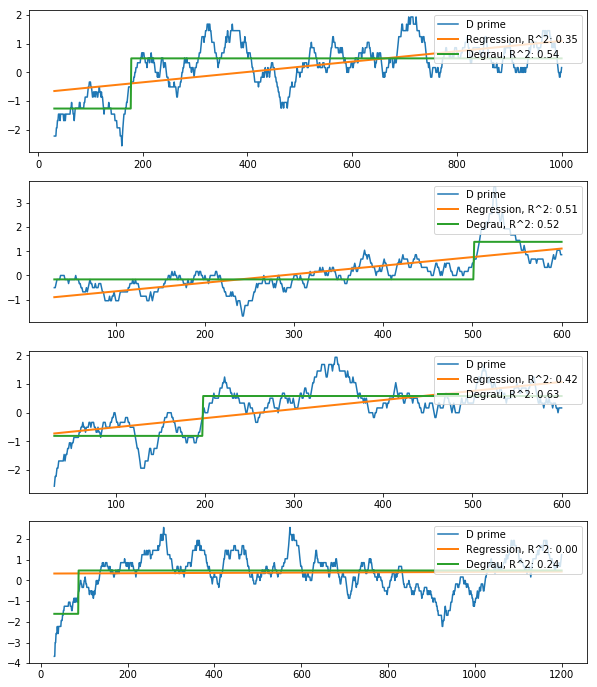

In [8]:
%%time

window = 30
plt.figure(figsize=(10,12))
for i, label in enumerate(['DRRD 7','DRRD 8','DRRD 9','DRRD 10']):
    b = select(io.load(label, 'behav_stats'), is_tired =False)
    b['rewarded'] = (b.duration>1.5)

    y = b.rewarded.rolling(window).apply(dprime)[window:]
    x = b.index[window:]

    
    plt.subplot(4,1,1+i)
    l, s = compare_linear_vs_step(x, y);